In [1]:
#: the usual imports
import babypandas as bpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 18

### Prediction, Correlation, Regression

# Prediction

## Prediction Problems

* Predicting one characteristic based on another:
    - Given my height, how tall will my kid be as an adult?
    - Given my education level, what is my income?
    - Given my income, how much does my car cost?
    
* Two characteristics: one is known; one is unknown
* Have data for which we know both characteristics
* To predict, need an association

### Predict child height from height of parents

* Use mid-parent height as before.
* observation: Children of shorter parents tend to be shorter

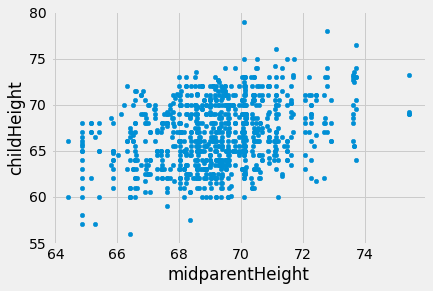

In [2]:
galton = bpd.read_csv('galton.csv')
galton.plot(kind='scatter', x='midparentHeight', y='childHeight')

### Predict child height from height of parents
* For a given child, predict their height by:
    - restricting ourselves to all midparents within $\pm 0.5$ inches of the child's midparent height;
    - averaging the height of all children of those midparents.

In [3]:
def predict_child(parent):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent.
    """
    close_points = galton[
        (galton.get('midparentHeight') <= parent + 0.5)
        &
        (galton.get('midparentHeight') >= parent - 0.5)
    ]
    return close_points.get('childHeight').mean()

with_predictions = galton.assign(
    Prediction=galton.get('midparentHeight').apply(predict_child)
)

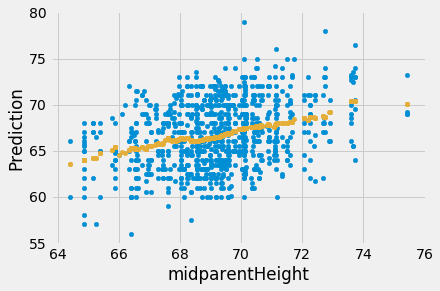

In [4]:
ax = with_predictions.plot(kind='scatter', x='midparentHeight', y='childHeight')
with_predictions.plot(kind='scatter', x='midparentHeight', y='Prediction', ax=ax, color='C2')

## Graph of Averages
A visualization of x and y pairs
* Group each x value with other nearby x values
* Average the corresponding y values for each group
* For each x value, produce one predicted y value

## Relations between two variables
* Association
* Trend
    - Positive association
    - Negative association
* Pattern
    - Any discernible "shape"
    - Linear
    - Non-Linear

## Variable relationships: hybrid cars

In [5]:
hybrid = bpd.read_csv('hybrid.csv')
hybrid

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
3,Insight,2000,18936.41,9.52,53.00,Two Seater
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact
...,...,...,...,...,...,...
148,S400,2013,92350.00,13.89,21.00,Large
149,Prius Plug-in,2013,32000.00,9.17,50.00,Midsize
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize


### Acceleration and price
* Is there an association?
* What kind of association?

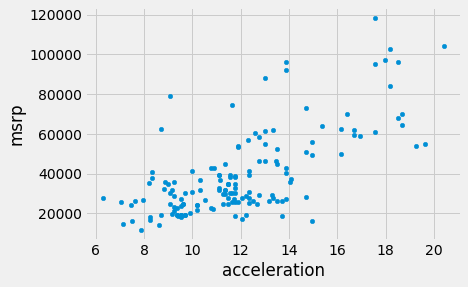

In [6]:
hybrid.plot(kind='scatter', x='acceleration', y='msrp')

### Fuel economy and price

* Is there an association?
* What kind of association?

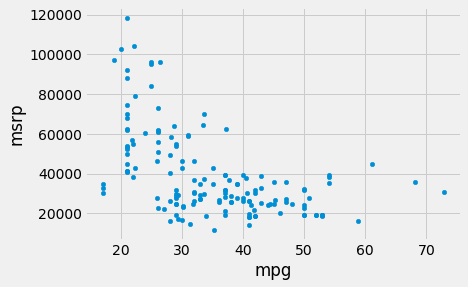

In [7]:
hybrid.plot(kind='scatter', x='mpg', y='msrp')

### Observations
* There is an association:
    - Are people more willing to pay less for certain cars because they want poor fuel economy?
* The association looks more curved than linear. Maybe like $~\frac{1}{x}$

### Understanding units 
* A linear change in units doesn't change the shape of the plot.
* The scale *does* change with the units.

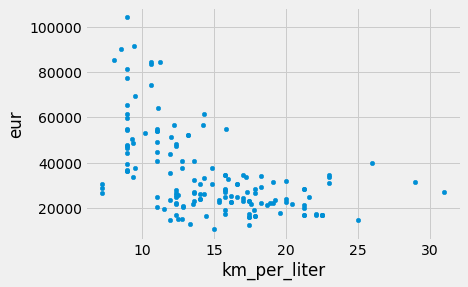

In [8]:
hybrid.assign(
        km_per_liter=hybrid.get('mpg') * 0.425144,
        eur=hybrid.get('msrp') * 0.88 
).plot(kind='scatter', x='km_per_liter', y='eur')

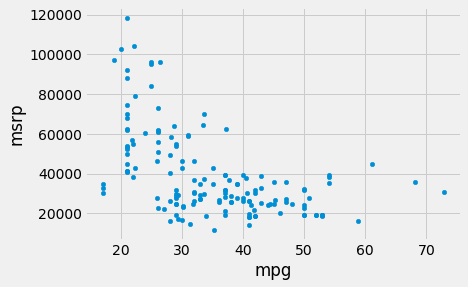

In [9]:
hybrid.plot(kind='scatter', x='mpg', y='msrp')

### Converting columns to standard units
* makes different scatterplots comparable
* allows x and y axis to be "similarly scaled"
    - both axes measure standard deviations from their means
* doesn't change shape of the scatterplot (conversion is linear)

In [10]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    any_numbers = np.array(any_numbers)
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

In [11]:
def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = bpd.DataFrame()
    for column in t.columns:
        t_su = t_su.assign(**{column + ' (su)': standard_units(t.get(column))})
    return t_su

### Standard units: hybrid cars
* For a given pair of variables:
    - which cars are average from both perspectives?
    - which cars are both well above/below average?

In [12]:
hybrid_su = standardize(hybrid.get(['msrp', 'acceleration','mpg']))
hybrid_su

,msrp (su),acceleration (su),mpg (su)
0,-0.693630,-1.535009,0.590910
1,-0.185680,-1.282501,1.764949
2,-0.584852,-1.360983,0.953911
3,-0.954663,-0.832081,1.664369
4,-0.631636,-1.678324,1.119410
...,...,...,...
148,2.483750,0.659081,-1.261584
149,-0.342814,-0.951510,1.390061
150,-0.298320,-0.067732,0.750009
151,-0.029012,-0.067732,0.750009


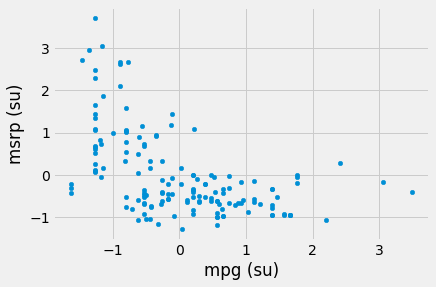

In [13]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='msrp (su)')

In [14]:
(
    hybrid_su
    .assign(vehicle=hybrid.get('vehicle'))
)[
    (hybrid_su.get('mpg (su)') <= 0.2)
    &
    (hybrid_su.get('mpg (su)') >= -0.2)
    &
    (hybrid_su.get('msrp (su)') <= 0.2)
    &
    (hybrid_su.get('msrp (su)') >= -0.2)
]

,msrp (su),acceleration (su),mpg (su),vehicle
57,-0.084707,0.723914,-0.105833,Audi Q5
67,0.168841,-0.402135,0.018520,Chevrolet Volt


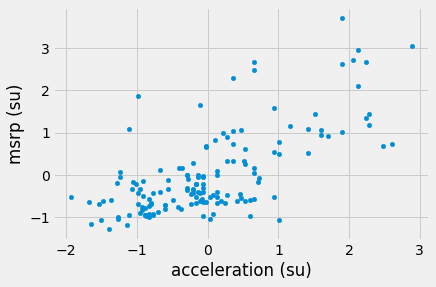

In [15]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='msrp (su)')

In [16]:
(
    hybrid_su
    .assign(vehicle=hybrid.get('vehicle'))
)[
    (hybrid_su.get('acceleration (su)') > 2)
    &
    (hybrid_su.get('msrp (su)') > 2)
]

,msrp (su),acceleration (su),mpg (su),vehicle
47,2.712681,2.047875,-1.460915,ActiveHybrid X6
60,3.043463,2.883881,-1.160090,ActiveHybrid 7
95,2.964086,2.122945,-1.353020,ActiveHybrid 7i
146,2.106719,2.122945,-0.895840,ActiveHybrid 7L
147,2.661728,2.238962,-0.895840,Panamera S


### Observation on associations in standard units
* If two attributes are positively associated,
    - their high, positive values in standard units are typically seen together,
    - their low, negative values are seen together as well.
* If two attributes are negatively associated,
    - high, positive values of one are typically coupled with low, negative values of the other.
* If two attributes aren't associated, there shouldn't be pattern in their relative sizes.

## Definition: Correlation Coefficient

**Definition**: The correlation coefficient $r$ of two attributes $x$ and $y$ is the average value of the product of $x$ and $y$ when measured in standard units.

* If `x` and `y` are arrays (i.e. columns in a table): 
```
r = (x_su * y_su).mean()
```
where `x_su` and `y_su` are `x` and `y` converted to standard units.


### Calculate the $r$ for `acceleration` and `msrp`

In [17]:
(
    hybrid_su
    .get(['acceleration (su)', 'msrp (su)'])
    .assign(
        Product=hybrid_su.get('acceleration (su)') * hybrid_su.get('msrp (su)')
    )
)

,acceleration (su),msrp (su),Product
0,-1.535009,-0.693630,1.064728
1,-1.282501,-0.185680,0.238135
2,-1.360983,-0.584852,0.795974
3,-0.832081,-0.954663,0.794357
4,-1.678324,-0.631636,1.060089
...,...,...,...
148,0.659081,2.483750,1.636993
149,-0.951510,-0.342814,0.326192
150,-0.067732,-0.298320,0.020206
151,-0.067732,-0.029012,0.001965


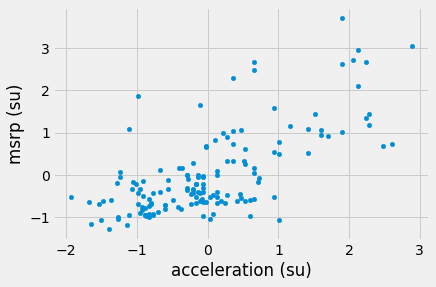

In [18]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='msrp (su)')

In [19]:
r = (
    hybrid_su.get('acceleration (su)') 
    * 
    hybrid_su.get('msrp (su)')
).mean()
r

0.6955778996913978

## The Correlation Coefficient $r$

* Measures how clustered points are around a straight line (linear association)
* Based on standard units
* $-1 \leq r \leq 1$
    - $r = 1$: scatterplot is a line of slope 1.
    - $r = -1$: scatterplot is a line of slope -1.
* $r = 0$: no linear association; *uncorrelated*.

### Calculate the $r$ for `mpg` and `msrp`

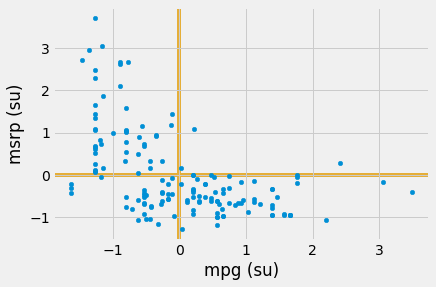

In [20]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='msrp (su)')
plt.axhline(color='C2', zorder=0)
plt.axvline(color='C2', zorder=0)

In [21]:
(
    hybrid_su
    .get(['mpg (su)', 'msrp (su)'])
    .assign(
        Product=hybrid_su.get('mpg (su)') * hybrid_su.get('msrp (su)')
    )
)

,mpg (su),msrp (su),Product
0,0.590910,-0.693630,-0.409873
1,1.764949,-0.185680,-0.327716
2,0.953911,-0.584852,-0.557897
3,1.664369,-0.954663,-1.588912
4,1.119410,-0.631636,-0.707059
...,...,...,...
148,-1.261584,2.483750,-3.133460
149,1.390061,-0.342814,-0.476533
150,0.750009,-0.298320,-0.223743
151,0.750009,-0.029012,-0.021759


In [22]:
#:
r = (hybrid_su.get('mpg (su)') * hybrid_su.get('msrp (su)')).mean()
r

-0.5318263633683786

## Scatterplots with given correlation coefficients

In [23]:
#:
def r_scatter(r):
    plt.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plt.scatter(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.suptitle('r = %f' %r, fontsize=14)

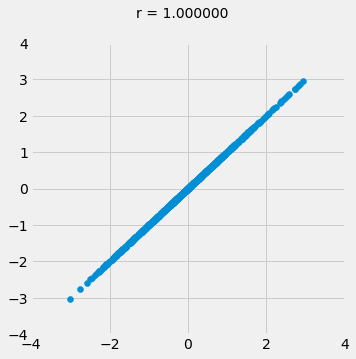

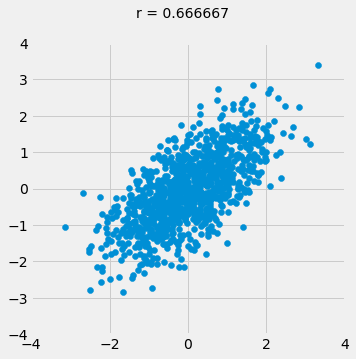

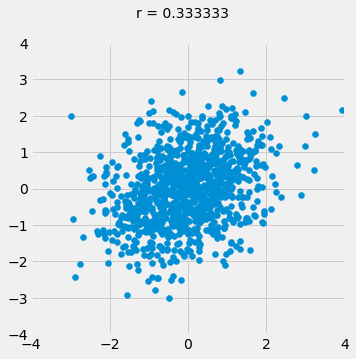

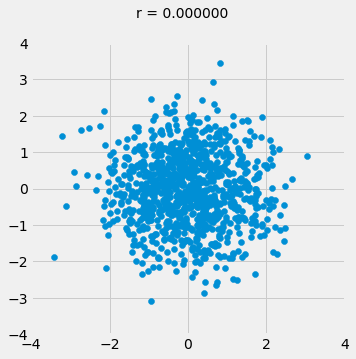

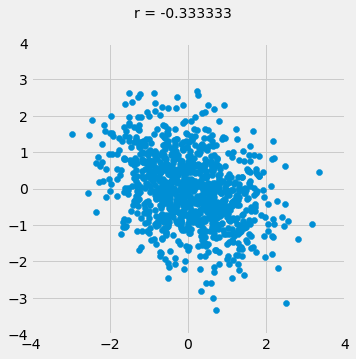

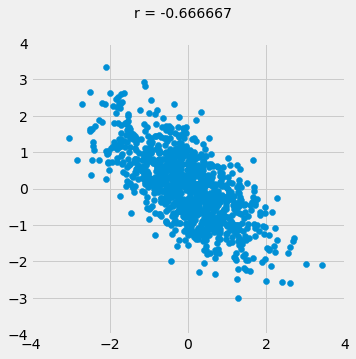

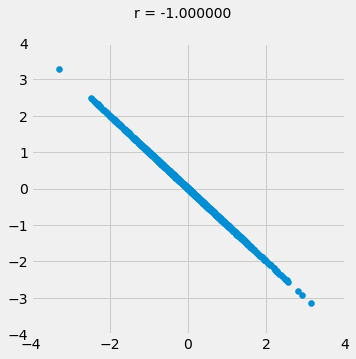

In [24]:
#:
for r in np.linspace(1, -1, 7):
    r_scatter(r)

### Discussion Question
Does the following scatter plot show:

- A. Association and correlation
- B. Association but not correlation
- C. Correlation but not association
- D. Neither association nor correlation

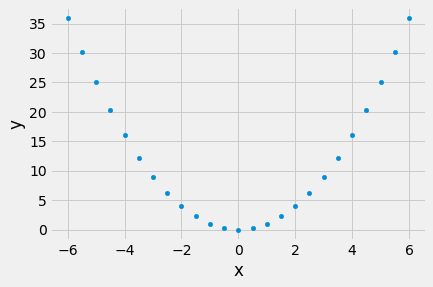

In [25]:
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5), 
    y=np.arange(-6, 6.1, 0.5)**2
)
x2.plot(kind='scatter', x='x', y='y')

### Answer

In [26]:
products = standard_units(x2.get('x')) * standard_units(x2.get('y'))
products

array([-3.2996324 , -2.26849727, -1.43462278, -0.78007614, -0.28692456,
        0.06276475,  0.28692456,  0.40348766,  0.43038683,  0.38555487,
        0.28692456,  0.15242867, -0.        , -0.15242867, -0.28692456,
       -0.38555487, -0.43038683, -0.40348766, -0.28692456, -0.06276475,
        0.28692456,  0.78007614,  1.43462278,  2.26849727,  3.2996324 ])

In [27]:
np.mean(products)

0.0

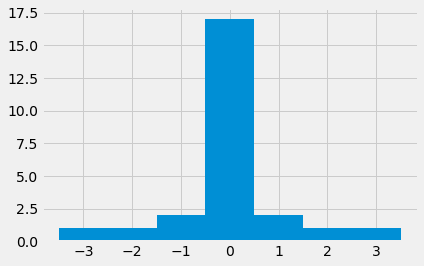

In [28]:
plt.hist(products, bins=np.arange(-3.5, 3.6));

## Child height prediction, revisited
* Calculate the correlation between `midparentHeight` and `childHeight`

In [29]:
heights_su = standardize(galton.get(['midparentHeight', 'childHeight']))
heights_su

,midparentHeight (su),childHeight (su)
0,3.454652,1.804156
1,3.454652,0.686005
2,3.454652,0.630097
3,3.454652,0.630097
4,2.472085,1.888017
...,...,...
929,-1.424873,-0.767591
930,-1.424873,-1.326667
931,-1.424873,-1.606205
932,-2.185390,-0.068747


In [30]:
r = (heights_su.get('midparentHeight (su)') * heights_su.get('childHeight (su)')).mean()
r

0.32094989606395924

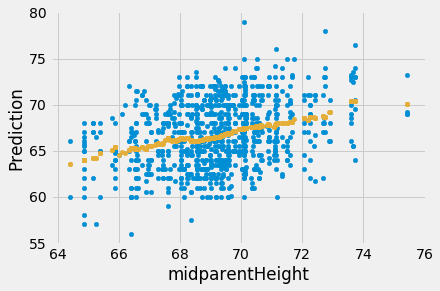

In [31]:
ax = with_predictions.plot(kind='scatter', x='midparentHeight', y='childHeight')
with_predictions.plot(kind='scatter', x='midparentHeight', y='Prediction', ax=ax, color='C2')

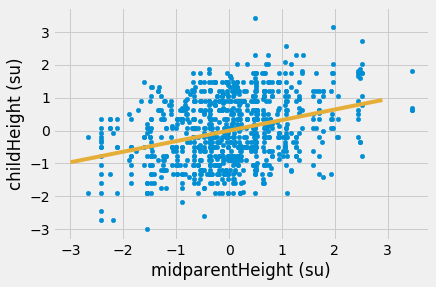

In [32]:
heights_su.plot(kind='scatter', x='midparentHeight (su)', y='childHeight (su)')
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1) * r, color='C2');

## Using the correlation coefficient for prediction
In standard units:
* The line through $(0,0)$ with slope $r$ is called the regression line.
* If the association between attributes is linear, the graph of averages is approximately the regression line.
* If the line is given by $f(x) = mx + b$, then the prediction for $x$ is given by $f(x)$.

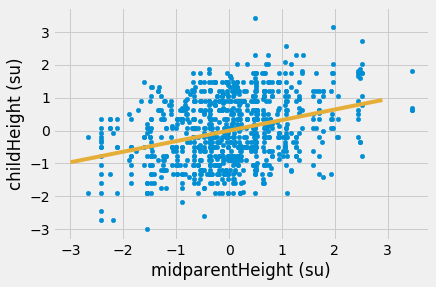

In [33]:
heights_su.plot(kind='scatter', x='midparentHeight (su)', y='childHeight (su)')
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1) * r, color='C2');

### Regression to the mean

* The regression line predicts:
    - Parent's whose mid-parent height is ~2 su have children with height ~0.6 su.
    - We predict that the child will be somewhat closer to average than their parents.
* This is a consequence of the slope having magnitude less than 1.

## Regression to the Mean
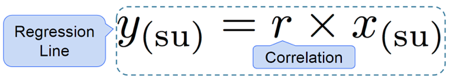

* If $r = 0.6$, and the given $x$ is 2 standard units, then:
    - The given $x$ is 2 SDs above average
    - The prediction for $y$ is 1.2 SDs above average

* On average (though not for each individual), regression predicts $y$ to be closer to the mean than $x$.

### Child height prediction, original units
Approach:
1. Scale mid-parent height to standard units
2. Use the correlation coefficient to predict child height
3. Scale predicted child height from standard units back to inches

In [42]:
#:
parent_mean = galton.get('midparentHeight').mean()
parent_sd = np.std(galton.get('midparentHeight'))
child_mean = galton.get('childHeight').mean()
child_sd = np.std(galton.get('childHeight'))

In [43]:
#:
def predict_with_r(parent):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent, 
    using linear regression.
    """
    parent_su = (parent - parent_mean) / parent_sd
    child_su = r * parent_su
    return child_su * child_sd + child_mean

In [44]:
predict_with_r(56)

58.32845077988057

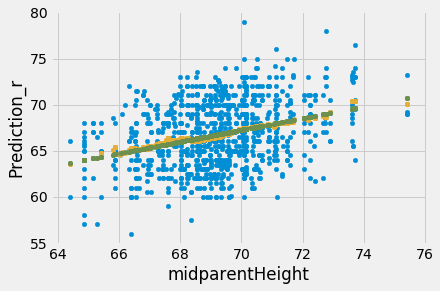

In [45]:
#:
preds = with_predictions.assign(
    Prediction_r=galton.get('midparentHeight').apply(predict_with_r)
)
ax = preds.plot(kind='scatter', x='midparentHeight', y='childHeight')
preds.plot(kind='scatter', x='midparentHeight', y='Prediction', ax=ax, color='C2')
preds.plot(kind='scatter', x='midparentHeight', y='Prediction_r', ax=ax, color='C3')

### Discussion Question

A course has a midterm (average 70; standard deviation 10) and a really hard final (average 50; standard deviation 12)

If the scatter diagram comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

- A.76
- B.90
- C.68
- D.82
- E.67.5

### Answer

1. (90 - 70)/10 = 2 standard units on midterm, 
2. estimate 0.75 * 2 = 1.5 standard units on final 
3. estimated final score = 1.5 * 12 + 50 = 68 points

## Slope and Intercept

* What does the regression line look like in original units?

## Regression line equation

In original units, the regression line has this equation:

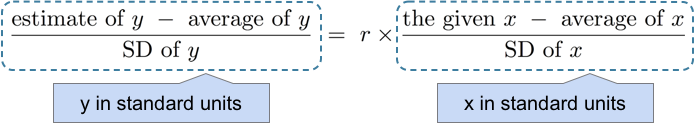


## Regression line equation:

* In standard units:
$$ y = r \times x $$
* In original units, 
    - where $m_x$, $m_y$ are the averages of $x$ and $y$
    - where $s_x$, $s_y$ are the standard deviations of $x$ and $y$,
$$\frac{(y - m_y)}{s_y} = r \times \frac{(x - m_x)}{s_x}$$
* This equation reworked into the point-slope form of a line:
$$(y - m_y) = \left(\frac{r\cdot s_y}{s_x}\right)(x - m_x)$$

* Or in the slope-intercept form:

$$y = \left(\frac{r\cdot s_y}{s_x}\right)x + \left(m_y - \frac{r\cdot s_y\cdot m_x}{s_x}\right)$$

## Slope and intercept

* The regression line is given by $y = mx + b$, where:
    - the slope $m$ is: $$m = r\cdot\frac{SD\ of\ x}{SD\ of\ y}$$
    - the y-intercept $b$ is: $$b = (avg\ of\ y) - m\cdot(avg\ of\ x)$$


## The regression line
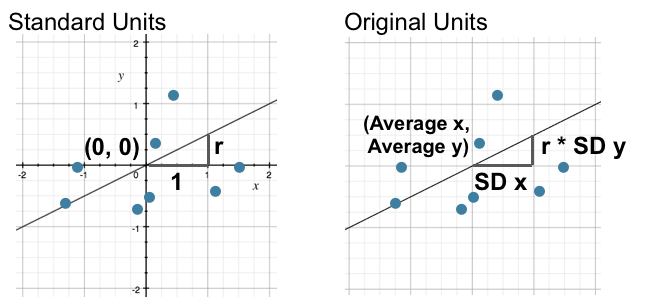

### Predict the retail price of a hybrid with acceleration of 12.5
* For each additional unit of acceleration (kph/s), how does the price change?

In [38]:
#:
def correlation(t, x, y):
    return np.mean(standard_units(t.get(x))*standard_units(t.get(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)"""
    r = correlation(t, x, y)
    return r * np.std(t.get(y)) / np.std(t.get(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)"""
    return t.get(y).mean() - slope(t, x, y) * t.get(x).mean()


In [39]:
m = slope(hybrid, 'acceleration', 'msrp')
b = intercept(hybrid, 'acceleration', 'msrp')

y = m * 12.5 + b
y

42063.58975574111

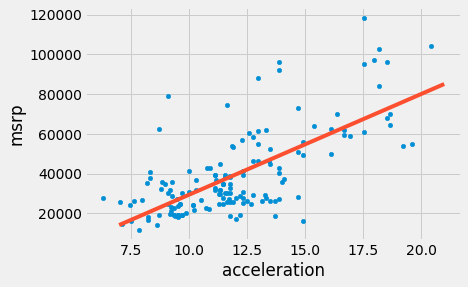

In [40]:
hybrid.plot(kind='scatter', x='acceleration', y='msrp')
x = np.arange(7,22)
plt.plot(x, m * x + b, color='C1');

In [41]:
m

5067.6611059552215